In [1]:
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

x_set = []
y_set = []

with open("dialog_acts.dat", 'r') as file:
    for line in file:
        y_set.append(line.split()[0])
        x_set.append(" ".join(line.split()[1:]).lower())
    # dialog_dataset = file.read()

y_set[0], x_set[0]
    

('inform', 'im looking for a moderately priced restaurant that serves')

In [3]:
# x_train, x_test = x_set[int(len(x_set)*0.15):], x_set[:int(len(x_set)*0.15)]
# y_train, y_test = y_set[int(len(y_set)*0.15):], y_set[:int(len(y_set)*0.15)]
# len(x_train), len(x_test), len(y_train), len(y_test)

In [4]:
#maybe split it in train, test and dev?

x_train, x_test = x_set[int(len(x_set)*0.15):], x_set[:int(len(x_set)*0.15)]
y_train, y_test = y_set[int(len(y_set)*0.15):], y_set[:int(len(y_set)*0.15)]
len(x_train), len(x_test), len(y_train), len(y_test)

x_train_no_duplicates = set(x_train)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_train, word_list = pd.factorize(y_train)
y_test = pd.factorize(y_test)[0]
def to_cat(data, num_tokens):
    encoder = keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode="one_hot")
    y_train_cat = encoder(data)
    return y_train_cat


y_train_cat= to_cat(y_train, 15)
y_test_cat = to_cat(y_test, 15)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.15, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)


(21675, 3826, 21675, 3826)

## Dummy baseline

In [6]:
def dummy_baseline(query: str) -> str:
    return max(set(y_train), key=y_train.count)

In [7]:
print(dummy_baseline('hi'))

inform


In [8]:
dummy_baseline_acc = y_test.count('inform') / len(y_test)
print(dummy_baseline_acc)

0.40041819132253004


## Rule-based baseline : TODO

In [9]:
def rule_based_baseline(query: str, keywords_dict: dict[str, str]):
    for key, value in keywords_dict.items():
        for keyword in value:
            if keyword in query:
                return key

In [10]:
if ['no', 'yes'] in 'no':
    print('Aha')

TypeError: 'in <string>' requires string as left operand, not list

In [28]:
query = 'yss'
if any(keyword in query for keyword in ['yes', 'no']):
    print('aha')
    
    

In [8]:
keyword_dict = {
    'ack': ['kay', 'okay', 'good', 'fine'],
    'affirm': ['yes', 'right', 'correct', 'yeah', 'ye'],
    'bye': ['good', 'bye'],
    'confirm': ['does', 'is', 'it', 'they', 'there'],
    'deny': ['wrong', 'want', 'dont'],
    'hello': ['hi', 'hello', 'im', 'looking'],
    'inform': ['any', 'food', 'care', 'expensive', 'moderate', 'cheap', 'east', 'west', 'north', 'south', 'centre', 'care', 'town', 'area'],
    'negate': ['no'],
    'null': ['unintelligible', 'noise', 'okay', 'what', 'uh', 'sil', 'laughing'],
    'repeat': ['repeat', 'back', 'go', 'again'],
    'reqalts': ['else', 'next', 'how', 'about', 'any', 'anything'],
    'reqmore': ['more'],
    'request': ['type', 'phone', 'number', 'address'],
    'restart': ['start', 'over', 'reset'],
    'thankyou': ['thank', 'you', 'good', 'bye'],
}

In [30]:
positive = 0
for x in range(len(y_set)):
    pred = rule_based_baseline(x_set[x], keyword_dict)
    if (x_set[x] == pred):
        positive = positive+1
rate = positive / len(y_set)
print('Rate: ', rate)

 

Rate:  0.0011764244539429827


In [11]:
#Doc2Vec (Sentences to vector)
#We use this to convert the whole input paragraph to a vector
#Upon reading the exercise again, they seem to suggest using bag-of-words. However, I think this is better. Lets discuss with the TA!
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

tagged_x_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(x_train)]
model = Doc2Vec(vector_size=50,
                min_count=2, epochs=50)
#print(tagged_x_data)
model.build_vocab(tagged_x_data)
model.train(tagged_x_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

def to_vector(list_of_words):
    vectorized = [model.infer_vector(word_tokenize(doc.lower())) for doc in list_of_words]
    return np.array(vectorized)

 

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [12]:
#bag of words implementation
#src: https://www.askpython.com/python/examples/bag-of-words-model-from-scratch

from collections import defaultdict, Counter
import regex as re
def tokenization(data):
    tokenized = []
    for sent in data:
        tokens = word_tokenize(sent)
        token_sent = [w.lower() for w in tokens if w.isalpha() ]
        tokenized.extend(token_sent)
    tokenized = sorted(list(set(tokenized)))
    return tokenized

def word_extraction(sentence):    
    #ignore = ['a', "the", "is"]
    ignore = []    
    words = re.sub("[^\w]", " ",  sentence).split()    
    cleaned_text = [w.lower() for w in words if w not in ignore]    
    return cleaned_text


def generate_vec(data, vocab):
    vectors =[]
    for sentence in data:                
        bag_vector = np.zeros(len(vocab))  
        words = word_extraction(sentence)    
        for w in words:            
            for i,word in enumerate(vocab):               
                if word == w:                     
                    bag_vector[i] += 1
        vectors.append(bag_vector)
    return vectors

def generate_bow(train, test):       
    vocab = tokenization(train)  
    train =generate_vec(train, vocab)
    test = generate_vec(test, vocab)
    return train, test

x_train_bow, x_test_bow = generate_bow(x_train, x_test)
#bag_of_words(x_train_tokenized, vocab, word_with_index)



In [13]:
document_vectors = to_vector(x_train)
x_test_vector = to_vector(x_test)

In [14]:
def plot(history, epochs):
    fig, ax = plt.subplots()
    ax.plot(history.history["loss"], label = "loss")
    ax.plot(history.history["val_loss"], label = "Valditation loss")
    ax.set_title(f"Loss in {epochs} epochs")
    fig.legend()

    fig2, ax2 = plt.subplots()
    ax2.plot(history.history["accuracy"], label = "accuracy")
    ax2.plot(history.history["val_accuracy"], label = "Validation accuracy")
    ax2.set_title(f"Accuracy in {epochs} epochs")
    fig2.legend()


Epoch 1/12


339/339 [==============================] - 2s 6ms/step - loss: 0.4885 - accuracy: 0.9021 - val_loss: 1.3517 - val_accuracy: 0.8060
Epoch 2/12
339/339 [==============================] - 2s 6ms/step - loss: 0.1112 - accuracy: 0.9692 - val_loss: 1.6289 - val_accuracy: 0.8068
Epoch 3/12
339/339 [==============================] - 2s 5ms/step - loss: 0.0752 - accuracy: 0.9806 - val_loss: 1.8110 - val_accuracy: 0.8068
Epoch 4/12
339/339 [==============================] - 2s 5ms/step - loss: 0.0596 - accuracy: 0.9847 - val_loss: 1.9559 - val_accuracy: 0.8102
Epoch 5/12
339/339 [==============================] - 2s 5ms/step - loss: 0.0506 - accuracy: 0.9873 - val_loss: 2.0780 - val_accuracy: 0.8089
Epoch 6/12
339/339 [==============================] - 1s 4ms/step - loss: 0.0438 - accuracy: 0.9886 - val_loss: 2.1608 - val_accuracy: 0.8063
Epoch 7/12
339/339 [==============================] - 1s 4ms/step - loss: 0.0386 - accuracy: 0.9901 - val_loss: 2.2222 - val_accuracy: 0.8102
Epo

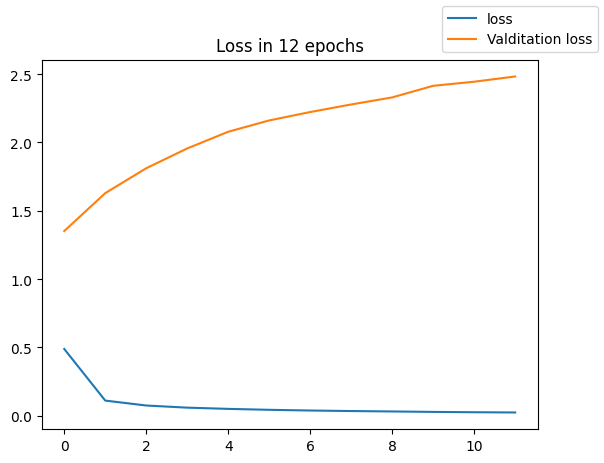

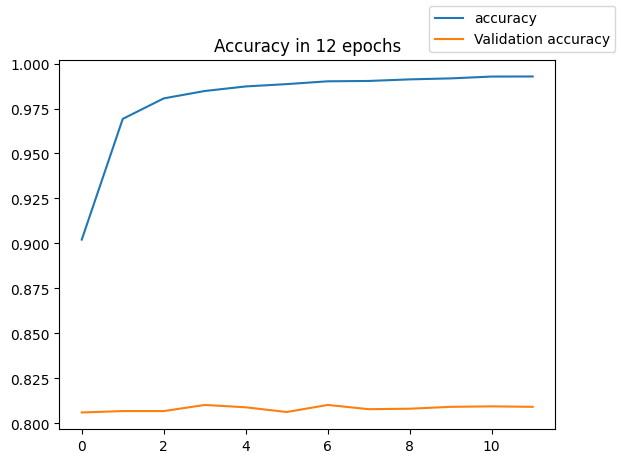

In [15]:
#FNN with BOW

epochs = 12
model_FNN = keras.Sequential()
model_FNN.add(keras.Input(shape=(731,)))
model_FNN.add(keras.layers.Dense(256, activation="relu"))
model_FNN.add(keras.layers.Dense(15, activation="softmax"))

model_FNN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_FNN.fit(np.array(x_train_bow), y_train_cat, batch_size=64,
epochs=epochs, verbose=1,validation_data=(np.array(x_test_bow), y_test_cat))

plot(history, epochs)

Epoch 1/12
339/339 [==============================] - 1s 3ms/step - loss: 0.8096 - accuracy: 0.7914 - val_loss: 1.1868 - val_accuracy: 0.7684
Epoch 2/12
339/339 [==============================] - 1s 2ms/step - loss: 0.3803 - accuracy: 0.9008 - val_loss: 1.3947 - val_accuracy: 0.7757
Epoch 3/12
339/339 [==============================] - 1s 2ms/step - loss: 0.3106 - accuracy: 0.9151 - val_loss: 1.5561 - val_accuracy: 0.7783
Epoch 4/12
339/339 [==============================] - 1s 3ms/step - loss: 0.2709 - accuracy: 0.9255 - val_loss: 1.6537 - val_accuracy: 0.7875
Epoch 5/12
339/339 [==============================] - 1s 2ms/step - loss: 0.2429 - accuracy: 0.9321 - val_loss: 1.7757 - val_accuracy: 0.7885
Epoch 6/12
339/339 [==============================] - 1s 2ms/step - loss: 0.2229 - accuracy: 0.9352 - val_loss: 1.8233 - val_accuracy: 0.7919
Epoch 7/12
339/339 [==============================] - 1s 3ms/step - loss: 0.2067 - accuracy: 0.9396 - val_loss: 1.8538 - val_accuracy: 0.7932
Epoch 

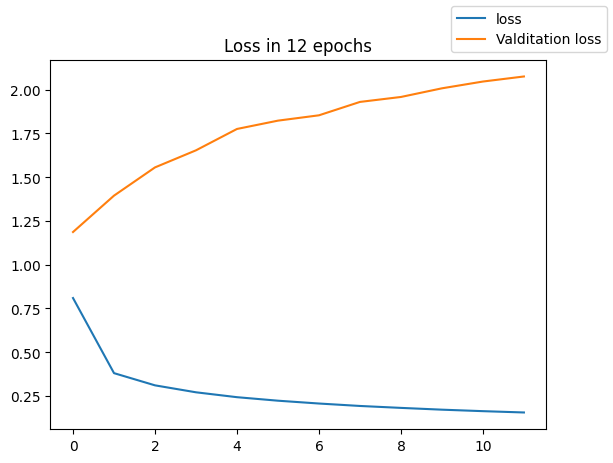

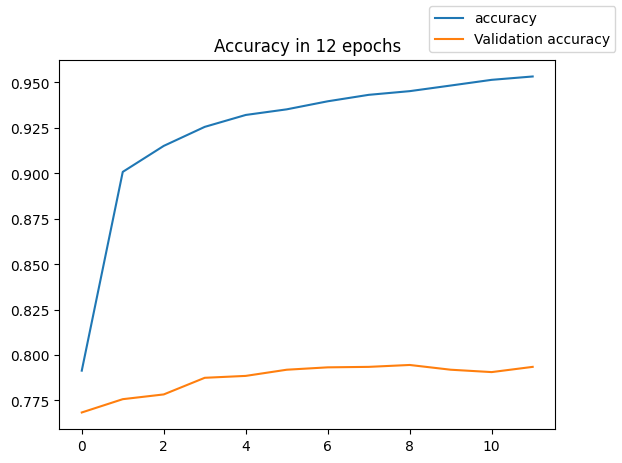

In [16]:
#FNN with word embeddings
epochs = 12
model_FNN = keras.Sequential()
model_FNN.add(keras.Input(shape=(50,)))
model_FNN.add(keras.layers.Dense(256, activation="relu"))
model_FNN.add(keras.layers.Dense(15, activation="softmax"))

model_FNN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_FNN.fit(document_vectors, y_train_cat, batch_size=64,
epochs=12, verbose=1,validation_data=(x_test_vector, y_test_cat))

plot(history, epochs)

Epoch 1/12
339/339 [==============================] - 1s 3ms/step - loss: 1.8648 - accuracy: 0.7990 - val_loss: 1.4274 - val_accuracy: 0.7835
Epoch 2/12
339/339 [==============================] - 1s 2ms/step - loss: 1.0019 - accuracy: 0.8993 - val_loss: 1.1048 - val_accuracy: 0.7846
Epoch 3/12
339/339 [==============================] - 1s 2ms/step - loss: 0.6671 - accuracy: 0.9051 - val_loss: 1.0357 - val_accuracy: 0.7846
Epoch 4/12
339/339 [==============================] - 1s 2ms/step - loss: 0.4963 - accuracy: 0.9051 - val_loss: 1.0351 - val_accuracy: 0.7953
Epoch 5/12
339/339 [==============================] - 1s 2ms/step - loss: 0.3943 - accuracy: 0.9177 - val_loss: 1.0604 - val_accuracy: 0.7950
Epoch 6/12
339/339 [==============================] - 1s 3ms/step - loss: 0.3282 - accuracy: 0.9319 - val_loss: 1.0920 - val_accuracy: 0.7963
Epoch 7/12
339/339 [==============================] - 1s 3ms/step - loss: 0.2828 - accuracy: 0.9379 - val_loss: 1.1265 - val_accuracy: 0.7997
Epoch 

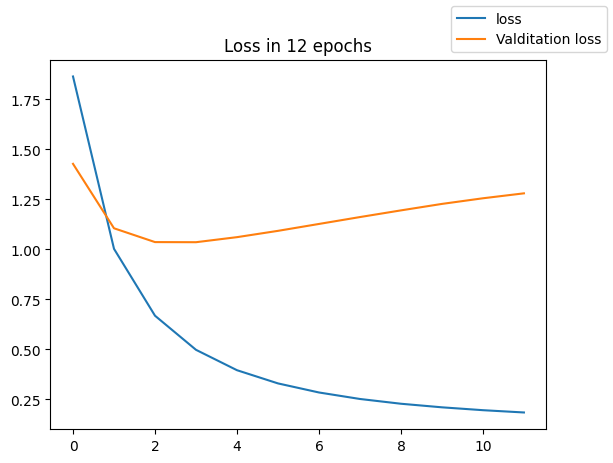

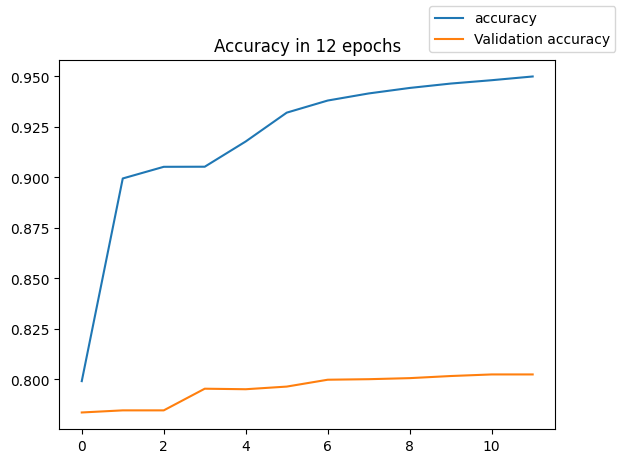

In [17]:
# Logistic regression with BOW
model_LR = keras.Sequential()
model_LR.add(keras.Input(shape=(731,)))
model_LR.add(keras.layers.Dense(15, activation="softmax"))

model_LR.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_LR.fit(np.array(x_train_bow), y_train_cat, batch_size=64, epochs=12, verbose=1,
                       validation_data=(np.array(x_test_bow), y_test_cat))

plot(history, epochs)

Epoch 1/12
339/339 [==============================] - 1s 3ms/step - loss: 2.0662 - accuracy: 0.5790 - val_loss: 1.6834 - val_accuracy: 0.7085
Epoch 2/12
339/339 [==============================] - 1s 2ms/step - loss: 1.3211 - accuracy: 0.7046 - val_loss: 1.3632 - val_accuracy: 0.7205
Epoch 3/12
339/339 [==============================] - 1s 4ms/step - loss: 1.0335 - accuracy: 0.7226 - val_loss: 1.2559 - val_accuracy: 0.7252
Epoch 4/12
339/339 [==============================] - 1s 2ms/step - loss: 0.8793 - accuracy: 0.7374 - val_loss: 1.2083 - val_accuracy: 0.7318
Epoch 5/12
339/339 [==============================] - 1s 3ms/step - loss: 0.7807 - accuracy: 0.7853 - val_loss: 1.1874 - val_accuracy: 0.7380
Epoch 6/12
339/339 [==============================] - 1s 2ms/step - loss: 0.7125 - accuracy: 0.8157 - val_loss: 1.1825 - val_accuracy: 0.7461
Epoch 7/12
339/339 [==============================] - 1s 2ms/step - loss: 0.6635 - accuracy: 0.8339 - val_loss: 1.1830 - val_accuracy: 0.7498
Epoch 

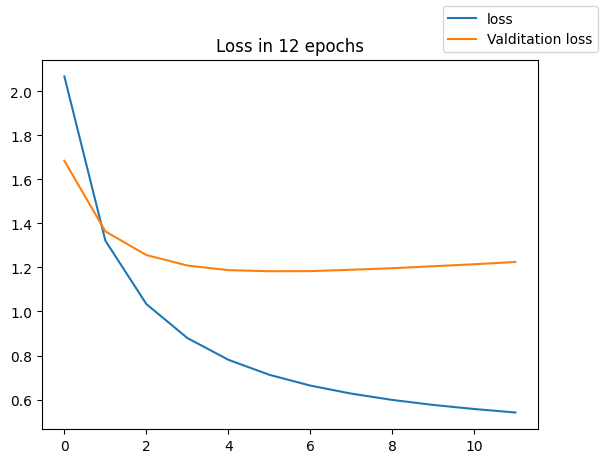

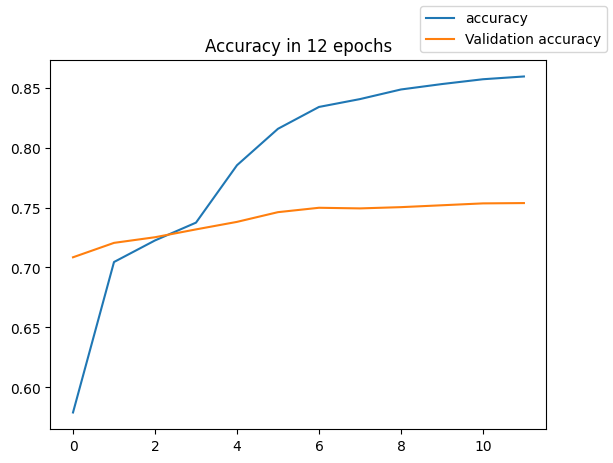

In [18]:
# Logistic regression with word embeddings
model_LR = keras.Sequential()
model_LR.add(keras.Input(shape=(50,)))
model_LR.add(keras.layers.Dense(15, activation="softmax"))

model_LR.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_LR.fit(document_vectors, y_train_cat, batch_size=64, epochs=12, verbose=1,
                       validation_data=(x_test_vector, y_test_cat))

plot(history, epochs)

In [19]:

Xnew = ["yes", "thai food", "what is the cheapest restaurant in london?"]
# make a prediction
X_new_vector = to_vector(Xnew)
X_new_vector = np.array(X_new_vector)
ynew = model_LR.predict(X_new_vector)
# show the inputs and predicted outputs

for i in range(len(Xnew)):
 print("X=%s, Predicted=%s" % (Xnew[i], word_list[np.argmax(ynew[i])]))

1/1 [==============================] - 0s 197ms/step
X=yes, Predicted=affirm
X=thai food, Predicted=inform
X=what is the cheapest restaurant in london?, Predicted=request
